In [44]:
from pathlib import Path
from ml_utils import CustomDataset
from torch.utils.data import DataLoader

import torch
from model.resnet_model import CNNClassifier

from lime import lime_image
from skimage.segmentation import mark_boundaries

from matplotlib import pyplot as plt

### Load the dataset

In [45]:
train_dt = CustomDataset(data_path=Path("../datasets/car_dataset"), portion="test")
train_loader = DataLoader(train_dt, batch_size=2, shuffle=True, num_workers=4)

### Load the pretrained model

In [46]:
cls = CNNClassifier(num_classes=196, pretrained=True, model_name="resnet18", freeze_layers=0)
cls.load_state_dict(torch.load("../experiments/results/r18_pretrained_fre0.pth", weights_only=True))
cls.eval()

CNNClassifier(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [47]:
dt_iter = iter(train_loader)
X, y = next(dt_iter)

In [48]:
with torch.no_grad():
    y_hat = torch.softmax(cls(X), dim=1)

In [51]:
def batch_predict(images):
    images = torch.from_numpy(images).permute(0,3,1,2)
    with torch.no_grad():
        logits = cls(images)
        probs = torch.softmax(logits, dim=1)
        return probs.numpy()

In [86]:
image_explainer = lime_image.LimeImageExplainer()
image_explanation = image_explainer.explain_instance(X[1].permute(1,2,0).numpy(), # our image converted to the form of a numpy array
                                         batch_predict, # predict function
                                         top_labels=1,
                                         hide_color=0,
                                         num_samples=512) # size of the neighborhood to learn the linear model

temp, mask = image_explanation.get_image_and_mask(image_explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
img_boundry = mark_boundaries(temp/255.0, mask)

  0%|          | 0/512 [00:00<?, ?it/s]

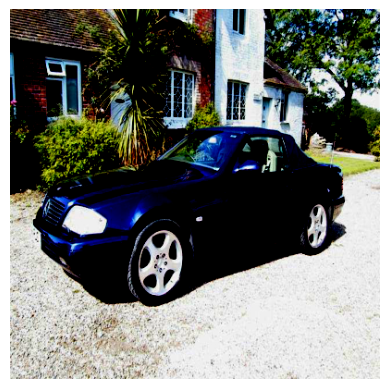

In [89]:
plt.imshow(torch.clamp(X[1].permute(1,2,0),0,1))
plt.axis('off')
plt.show()

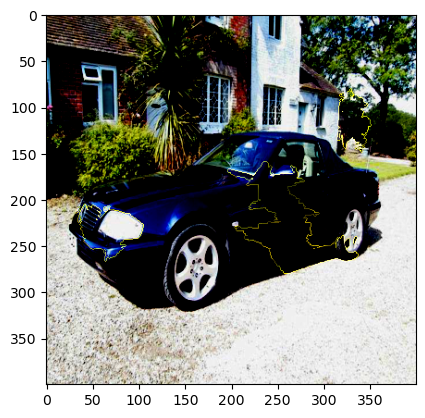

In [90]:
plt.imshow(torch.clamp(X[1].permute(1,2,0) + img_boundry ,0,1))
plt.show()